In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3 # 최신 버전으로 설치하면 "Input: must be Tensor, not str" 라는 에러 발생
!pip install torch

!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-3.0.0-py3-none-any.whl (754 kB)
  Using cached tokenizers-0.8.0rc4-cp37-cp37m-manylinux1_x86_64.whl (3.0 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import pandas as pd
from tqdm import tqdm_notebook

In [3]:
##GPU 사용 시
device = torch.device("cuda:0")

bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 데이터 전처리


In [50]:
import pandas as pd

In [51]:
df1 = pd.read_excel('/content/drive/MyDrive/Dialog-KoELECTRA/pretrain/setiment_data/감성대화말뭉치(최종데이터)_Training.xlsx')
df1.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN


In [52]:
df2 = pd.read_excel('/content/drive/MyDrive/Dialog-KoELECTRA/pretrain/setiment_data/감성대화말뭉치(최종데이터)_Validation.xlsx')
df2.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN
3,169,청년,남성,"진로, 취업, 직장",해당없음,당황,죄책감의,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.,팀장님이 부탁하신 업무를 잘못 처리하셔서 많이 당황하시고 놀라셨겠어요.,곧 있으면 인턴에서 정규직 전환 평가가 있는데 안 좋을 것 같아.,마음이 많이 안 좋으시겠어요. 지금 상황을 타개할 수 있는 가장 좋은 방안이 있을까요?,우선 잘못된 부분을 솔직하게 말씀드리고 수정하기 위해서 최선을 다해봐야겠어.,잘못된 부분을 잘 수정해서 좋은 결과가 있었으면 좋겠어요.,NaN,NaN
4,38435,중년,여성,"재정, 은퇴, 노후준비",해당없음,분노,노여워하는,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.,많이 화가 나시겠어요.,어떻게 그럴 수가 있지? 너무 화가 나.,어떻게 하면 지금의 감정을 추스를 수 있을까요?,나도 변호사를 고용해서 한번 얘기해보려고 해.,자녀분들이랑 함께 하며 슬픔을 극복하시길 바라요.,NaN,NaN


In [53]:
df2[df2['사람문장4'].notnull()]

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
57,50760,청소년,남성,가족관계,해당없음,당황,남의 시선을 의식하는,저녁때 가족들이 모여서 식사하는데 엄마가 옷에 밥풀이 묻었다고 해서 부끄러웠어.,사용자님의 옷에 밥풀이 묻어서 부끄러우셨군요.,가족들이 다 있는 앞에서 지적을 당하니까 어린애 같이 느껴져서 창피했어.,어린애 같은 기분이 들어서 창피하셨군요. 어떻게 하고 싶으세요?,엄마한테 실수에 대해 다른 방식으로 얘기해 달라고 얘기를 해 볼까 싶어.,어머니한테 그렇게 얘기하셔서 어떤 점이 달라지기를 원하시나요?,다음에 이런 일이 또 있을 때는 엄마가 나한테 조용히 말해주셨으면 좋겠어.,어머니와의 대화가 잘 되셨으면 좋겠어요.
113,49483,청년,남성,"진로, 취업, 직장",해당없음,분노,구역질 나는,취업 못 하는 친구들을 비하하는 사람이 있는데 더 이상 친구로는 지낼 수 없을 것 같아.,그런 생각이 들어 화가 나겠어요.,응. 취업을 못 할 수도 있는 건데 계속 그걸 가지고 사람을 깎아 내리니까.,지금 감정에서 조금이라도 벗어나기 위해 해볼 수 있는 일들에는 무엇이 있을까요?,그 사람한테 내 생각을 얘기해보려고.,어떤 얘기를 하실 생각이신가요?,취업난이 심각한 상황에 무작정 취준생을 비하하는 건 물정을 모르는 것 같다고 상처주...,이야기를 통해 사용자님의 의견이 전달되면 좋겠어요.
137,50537,중년,여성,"대인관계(부부, 자녀)",해당없음,불안,혼란스러운,우리 아들이 자기가 남자인지 잘 모르겠다고 했어. 성 정체성에 혼란이 왔나 봐.,아드님께서 남자인지 잘 모르겠다고 말씀하셨군요. 혼란스러우시겠어요.,아들 핸드폰에 남자랑 스킨십하는 사진이 엄청 많았어. 너무 충격적이고 혼란스러워.,아드님의 사진을 보고 큰 충격을 받으셨겠어요. 이런 상황에서 어떻게 하면 좋을까요?,아들과 한 번 진솔한 대화를 나누어봐야겠어.,아들과 대화를 나누면 어떤 점이 좋을까요?,아들의 솔직한 마음과 진지한 이야기를 들을 수 있을거야.,아드님과의 이야기를 통해 잘 해결되었으면 좋겠어요.
152,49493,청년,남성,"진로, 취업, 직장",해당없음,슬픔,낙담한,내가 모든 노력을 투자한 업무가 무의미해져 버려서 너무 슬퍼.,그런 상황이 생겨 많이 낙담하시겠어요.,응. 내 시간까지 다 써가면서 정말 공들여 투자했던 업무인데 말이야.,지금 감정에서 조금이라도 벗어나기 위해 해볼 수 있는 일들에는 무엇이 있을까요?,우선 프로젝트 한다고 그동안 만나지 못했던 친구들을 만나야겠어.,친구들을 만나려고 하시는군요. 또 다른 계획도 있으신가요?,좋아하는 미드 새로운 시즌도 봐야지.,그런 일들을 하면서 기분 전환이 되었으면 좋겠어요.
252,50213,중년,남성,"대인관계(부부, 자녀)",해당없음,슬픔,후회되는,아들이 실업계 고등학교를 가서 빨리 취업하고 싶다고 했는데 그렇게 하라고 할 걸 그랬어.,아드님이 하고 싶다는 걸 못하게 했던 일이 있으셨군요.,아들이 일반 고등학교에 적응을 잘 못 해서 힘들어하네. 내가 아들을 힘들게 한 것 ...,못하게 한 일로 아드님이 힘들어진 것 같아 후회를 하시는군요.,지금이라도 아들과 솔직하게 이야기를 해보고 내가 지원할 것이 있으면 해주어야 마음이...,지금 상황에서 어떤 것들이 가능할까요?,맛있는 거라도 먹이면서 도와줄 거 없냐고 물어봐야겠어.,아드님과의 이야기를 하시면서 지금의 마음이 편안하게 풀리시기를 바라요.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5009,49695,청소년,남성,학교폭력/따돌림,해당없음,분노,방어적인,쉬는 시간에 선생님 몰래 같은 반 애들이 친구를 때리는 걸 봐서 화가 났어.,선생님이 없을 때 친구가 맞는 걸 봤군요. 화가 났겠어요.,평소에 행실이 나쁜 애들이었지만 그래도 학우를 때릴 줄은 몰랐어.,같은 반 친구에게 폭력을 쓸 줄은 몰랐겠어요. 또 친구를 때리지 않게 하려면 어떻게...,담임 선생님께 내가 본 걸 솔직하게 말씀드리면 도움이 될까?,담임 선생님께 말씀드릴지 고민하시는군요. 이렇게 하면 어떤 점에서 유익이 있을까요?,학교폭력위원회를 열어서 징계를 받게 할 수도 있어.,담임 선생님께 말씀 드리면 가해 학생들이 징계를 받게 될 수 있군요.
5036,50312,청소년,여성,학업 및 진로,해당없음,당황,혼란스러운,내가 좋아하는 일을 해야 할지 부모님이 원하는 일을 해야 할지 알 수 없어서 혼란스러워.,조금 더 자세히 말해줄 수 있어요?,내가 하고 싶은 일을 우선시하고 싶지만 부모님의 반대가 두려워.,어떻게 하면 그런 기분에서 벗어날 수 있을까요?,부모님께 의논 드려보고 내 의견을 존중해달라고 설득해봐야지.,부모님과 의논해 설득해 보려 하시는군요. 부모님을 설득하려면 어떤 것이 필요할까요?,내가 얼마나 이 일에 진심이고 좋아하는지를 말씀드려야지.,이 일에 대한 나의 열정을 말씀 드리려 하는군요.
5068,50113,노년,여성,대인관계,만성질환 무,당황,고립된,친구와 함께 가기로 한 여행을 나 혼자 가게 되었어. 조금 당황스러워.,함께 가기로 한 여행을 혼자 가야 한다니 당황스러우실 것 같아요.,친구가 디스크가 심해졌대. 같이 고향으로 가기로 한 여행이었는데 아쉬워.,친구가 디스크가 심해져서 못 가게 되었군요. 아쉬우시겠어요.,갑자기 혼자 여행을 가게 되었지만 고향이니 괜찮을 것 같아. 친구 몫까지 놀아야겠어.,혼자 여행을 가기 위해 어떤 것들을 준비해야 할까요?,숙소만 잡아놓으면 내가 잘 아는 곳이기 때문에 다른 건 준비할 게 없어!,오랜만에 고향에 가셔서 마음껏 즐기고 오셨으면 좋겠어요.
5100,49608,청소년,남성,학교폭력/따돌림,해당없음,슬픔,우울한,친구들과 싸움이 없는 날이 하루도 없네.,계속 싸운다니 마음이 암담하시겠어요.,주먹다짐 안 하고 어떻게 할 수 있을까.,주먹다짐 안 하기를 간절히 바라시군요.,응. 싸우면 부모님이 걱정을 하시니까.,어떻게 하면 싸우지 않고 친구들과 잘 지낼 수 있을까요?,아무래도 내가 먼저 싸우지 않도록 마음을 잘 다스리도록 해야겠어.,마음을 잘 다스려서 친구들과 잘 지냈으면 좋겠어요.


In [54]:
df2.iloc[57:58,:]

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
57,50760,청소년,남성,가족관계,해당없음,당황,남의 시선을 의식하는,저녁때 가족들이 모여서 식사하는데 엄마가 옷에 밥풀이 묻었다고 해서 부끄러웠어.,사용자님의 옷에 밥풀이 묻어서 부끄러우셨군요.,가족들이 다 있는 앞에서 지적을 당하니까 어린애 같이 느껴져서 창피했어.,어린애 같은 기분이 들어서 창피하셨군요. 어떻게 하고 싶으세요?,엄마한테 실수에 대해 다른 방식으로 얘기해 달라고 얘기를 해 볼까 싶어.,어머니한테 그렇게 얘기하셔서 어떤 점이 달라지기를 원하시나요?,다음에 이런 일이 또 있을 때는 엄마가 나한테 조용히 말해주셨으면 좋겠어.,어머니와의 대화가 잘 되셨으면 좋겠어요.


In [55]:
df3 = df1.iloc[:, 7:15]
df3['label'] = df1.iloc[:,5].str.strip()
df3.head()

,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN,기쁨
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN,불안
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.,당황
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN,기쁨
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN,기쁨


In [56]:
df4 = df1.iloc[:, 7:15]
df4['label'] = df1.iloc[:,6].str.strip()
df4.head()

,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN,신이 난
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN,스트레스 받는
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.,당황
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN,신이 난
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN,안도


In [57]:
df3.columns

Index(['사람문장1', '시스템응답1', '사람문장2', '시스템응답2', '사람문장3', '시스템응답3', '사람문장4',
       '시스템응답4', 'label'],
      dtype='object')

In [58]:
from tqdm import tqdm_notebook
doc_list = []
for i in tqdm_notebook(range((len(df3)))):
  doc = ''
  for j in range(0, 8):
    if (str(df3.iloc[i,j]) != 'NaN') and (str(df3.iloc[i,j]) != 'nan'):
      if j == 0:
        doc += str(df3.iloc[i,j])
      else :
        doc += ' [SEP] ' + str(df3.iloc[i,j])
  doc_list.append(doc)

df3['document'] = doc_list
df3 = df3[['document', 'label']]
df3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/40879 [00:00<?, ?it/s]

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나. [SEP] 아내분이 출산을 하시는군요...,기쁨
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야. [SEP] ...,불안
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. [SEP] ...,당황
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해. ...,기쁨
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어. [SEP] 기분 좋으시겠어요. ...,기쁨


In [59]:
df3.iloc[2, 0]

'고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. [SEP] 고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요. [SEP] 아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼. [SEP] 이 상황에서 할 수 있는 게 어떤 것이 있을까요? [SEP] 중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야. [SEP] 수업을 어떤 방식으로 열심히 듣는게 좋을까요?  [SEP] 선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해. [SEP] 열심히 해서 좋은 결과가 있었으면 좋겠어요.'

In [60]:
df3['label'].unique()

array(['기쁨', '불안', '당황', '슬픔', '분노', '상처'], dtype=object)

In [61]:
from tqdm import tqdm_notebook
doc_list = []
for i in tqdm_notebook(range((len(df3)))):
  doc = ''
  for j in range(0, 8):
    if (str(df4.iloc[i,j]) != 'NaN') and (str(df4.iloc[i,j]) != 'nan'):
      if j == 0:
        doc += str(df4.iloc[i,j])
      else :
        doc += ' [SEP] ' + str(df4.iloc[i,j])
  doc_list.append(doc)

df4['document'] = doc_list
df4 = df4[['document', 'label']]
df4.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/40879 [00:00<?, ?it/s]

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나. [SEP] 아내분이 출산을 하시는군요...,신이 난
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야. [SEP] ...,스트레스 받는
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. [SEP] ...,당황
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해. ...,신이 난
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어. [SEP] 기분 좋으시겠어요. ...,안도


In [62]:
df4.iloc[2, 0]

'고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. [SEP] 고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요. [SEP] 아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼. [SEP] 이 상황에서 할 수 있는 게 어떤 것이 있을까요? [SEP] 중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야. [SEP] 수업을 어떤 방식으로 열심히 듣는게 좋을까요?  [SEP] 선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해. [SEP] 열심히 해서 좋은 결과가 있었으면 좋겠어요.'

In [63]:
df4['label'].unique()

array(['신이 난', '스트레스 받는', '당황', '안도', '취약한', '우울한', '구역질 나는', '좌절한',
       '눈물이 나는', '배신당한', '남의 시선을 의식하는', '죄책감의', '당혹스러운', '분노', '두려운',
       '낙담한', '회의적인', '마비된', '혼란스러운', '흥분', '한심한', '염세적인', '안달하는',
       '걱정스러운', '조심스러운', '충격 받은', '상처', '불안', '노여워하는', '기쁨', '짜증내는',
       '환멸을 느끼는', '비통한', '혐오스러운', '억울한', '만족스러운', '부끄러운', '버려진', '고립된',
       '괴로워하는', '자신하는', '외로운', '방어적인', '편안한', '질투하는', '감사하는', '초조한',
       '실망한', '슬픔', '신뢰하는', '가난한, 불우한', '후회되는', '툴툴대는', '성가신', '열등감',
       '희생된', '느긋', '악의적인'], dtype=object)

In [64]:
df3.to_csv('/content/drive/MyDrive/Dialog-KoELECTRA/pretrain/setiment_data/sent_big_label_SEP_training_0713.csv', sep='\t', index=False)

In [65]:
df4.to_csv('/content/drive/MyDrive/Dialog-KoELECTRA/pretrain/setiment_data/sent_small_label_SEP_training_0713.csv', sep='\t', index=False)

In [66]:
df5 = df2.iloc[:, 7:15]
df5['label'] = df2.iloc[:,5].str.strip()
doc_list = []
for i in tqdm_notebook(range((len(df5)))):
  doc = ''
  for j in range(0, 8):
    if (str(df5.iloc[i,j]) != 'NaN') and (str(df5.iloc[i,j]) != 'nan'):
      if j == 0:
        doc += str(df5.iloc[i,j])
      else :
        doc += ' [SEP] ' + str(df5.iloc[i,j])
  doc_list.append(doc)

df5['document'] = doc_list
df5 = df5[['document', 'label']]
df5.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/5130 [00:00<?, ?it/s]

,document,label
0,요즘 부모님과 많이 부딪혀. [SEP] 어떤 일로 부딪히시나요? [SEP] 난 하고...,분노
1,엄마가 결국 집을 나갔어. 너무 너무 슬퍼. [SEP] 어머니께서 집을 나가셨다니 ...,슬픔
2,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어. [SEP] 용기 있는 행동을...,불안
3,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이...,당황
4,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어. [SEP] 많이 화가 ...,분노


In [72]:
df5.iloc[57, 0]

'저녁때 가족들이 모여서 식사하는데 엄마가 옷에 밥풀이 묻었다고 해서 부끄러웠어. [SEP] 사용자님의 옷에 밥풀이 묻어서 부끄러우셨군요. [SEP] 가족들이 다 있는 앞에서 지적을 당하니까 어린애 같이 느껴져서 창피했어. [SEP] 어린애 같은 기분이 들어서 창피하셨군요. 어떻게 하고 싶으세요? [SEP] 엄마한테 실수에 대해 다른 방식으로 얘기해 달라고 얘기를 해 볼까 싶어. [SEP] 어머니한테 그렇게 얘기하셔서 어떤 점이 달라지기를 원하시나요? [SEP] 다음에 이런 일이 또 있을 때는 엄마가 나한테 조용히 말해주셨으면 좋겠어. [SEP] 어머니와의 대화가 잘 되셨으면 좋겠어요.'

In [115]:
df6 = df2.iloc[:, 7:15]
df6['label'] = df2.iloc[:,6].str.strip()
doc_list = []
for i in tqdm_notebook(range((len(df6)))):
  doc = ''
  for j in range(0, 8):
    if j == 0:
        doc += str(df6.iloc[i,j])
    else :
        doc += ' [SEP] ' + str(df6.iloc[i,j])
  doc_list.append(doc)

df6['document'] = doc_list
df6 = df6[['document', 'label']]
df6.head()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/5130 [00:00<?, ?it/s]

,document,label
0,요즘 부모님과 많이 부딪혀. [SEP] 어떤 일로 부딪히시나요? [SEP] 난 하고...,툴툴대는
1,엄마가 결국 집을 나갔어. 너무 너무 슬퍼. [SEP] 어머니께서 집을 나가셨다니 ...,비통한
2,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어. [SEP] 용기 있는 행동을...,조심스러운
3,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이...,죄책감의
4,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어. [SEP] 많이 화가 ...,노여워하는


In [123]:
df6.iloc[57, 1]

'남의 시선을 의식하는'

In [74]:
df5.to_csv('/content/drive/MyDrive/Dialog-KoELECTRA/pretrain/setiment_data/sent_big_label_SEP_validation_0713.csv', sep='\t', index=False)

In [124]:
df6.to_csv('/content/drive/MyDrive/Dialog-KoELECTRA/pretrain/setiment_data/sent_small_label_SEP_validation_0713.csv', sep='\t', index=False)

# 데이터 입력


In [5]:
df3 = pd.read_csv('/content/drive/MyDrive/Dialog-KoELECTRA/pretrain/setiment_data/sent_big_label_SEP_training_0713.csv', sep='\t')
df5 = pd.read_csv('/content/drive/MyDrive/Dialog-KoELECTRA/pretrain/setiment_data/sent_big_label_SEP_validation_0713.csv', sep='\t')

(array([9.1030e+03, 2.7789e+04, 3.9120e+03, 7.3000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  64. ,  169.7,  275.4,  381.1,  486.8,  592.5,  698.2,  803.9,
         909.6, 1015.3, 1121. ]),
 <a list of 10 Patch objects>)

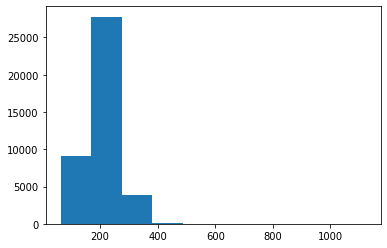

In [6]:
len_list = []
for i in range(len(df3)):
  len_list.append(len(df3.iloc[i, 0]))
import matplotlib.pyplot as plt
plt.hist(len_list)

(array([ 118.,  490.,  840., 1372., 1416.,  646.,  189.,   50.,    7.,
           2.]),
 array([ 66. , 104.1, 142.2, 180.3, 218.4, 256.5, 294.6, 332.7, 370.8,
        408.9, 447. ]),
 <a list of 10 Patch objects>)

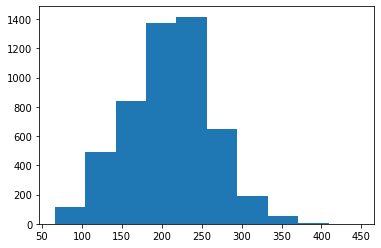

In [7]:
len_list = []
for i in range(len(df5)):
  len_list.append(len(df5.iloc[i, 0]))
import matplotlib.pyplot as plt
plt.hist(len_list)

In [8]:
df3['label'].value_counts()

불안    7329
분노    6920
슬픔    6915
기쁨    6731
상처    6624
당황    6360
Name: label, dtype: int64

In [11]:
display(df3.head())
display(df5.head())

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나. [SEP] 아내분이 출산을 하시는군요...,기쁨
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야. [SEP] ...,불안
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. [SEP] ...,당황
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해. ...,기쁨
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어. [SEP] 기분 좋으시겠어요. ...,기쁨


,document,label
0,요즘 부모님과 많이 부딪혀. [SEP] 어떤 일로 부딪히시나요? [SEP] 난 하고...,분노
1,엄마가 결국 집을 나갔어. 너무 너무 슬퍼. [SEP] 어머니께서 집을 나가셨다니 ...,슬픔
2,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어. [SEP] 용기 있는 행동을...,불안
3,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이...,당황
4,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어. [SEP] 많이 화가 ...,분노


In [12]:
label_list = df3['label'].unique()
data1 = df3[df3['label'] == label_list[0]]

for em in label_list[1:]:
    data_tmp = df3[df3['label'] == em]
    data1 = data1.append([data_tmp], sort=False)

new_data = pd.DataFrame(data1)
print(len(new_data))
new_data.head()


40879


,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나. [SEP] 아내분이 출산을 하시는군요...,기쁨
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해. ...,기쁨
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어. [SEP] 기분 좋으시겠어요. ...,기쁨
14,남편이 죽기 전에 손자들 얼굴 보고 싶다고 했는데 다행히 늦지 않아서 안도했어. [...,기쁨
23,친구가 사준 로또가 당첨이 됐어. [SEP] 축하드려요. 당첨금은 어떻게 하실 예정...,기쁨


In [13]:
new_data['label'].unique()

array(['기쁨', '불안', '당황', '슬픔', '분노', '상처'], dtype=object)

In [14]:
len(df5)

5130

In [15]:
label_list = df3['label'].unique()
data1 = df5[df5['label'] == label_list[0]]

for em in label_list[1:]:
    data_tmp = df5[df5['label'] == em]
    data1 = data1.append([data_tmp], sort=False)

new_data2 = pd.DataFrame(data1)
print(len(new_data2))
new_data2.head()


5130


,document,label
9,이 업무는 하루 만에 끝낼 수 있을 것 같아. [SEP] 업무를 하루 만에 끝낼 수...,기쁨
10,나 대학에 쉽게 갈 수 있을 것 같아. 학원 선생님들 실력이 정말 믿을 만해! [S...,기쁨
16,심혈을 기울여 작성한 기획안이 통과되었어! [SEP] 기획안이 드디어 통과되어 기쁘...,기쁨
21,좋아하던 선배에게 어제 고백을 받았어! [SEP] 좋아하던 분에게 고백을 받으시다니...,기쁨
26,오늘 반장 선거에서 내가 반장이 됐어! 친구들이 날 믿어줘서 너무 고맙다. [SEP...,기쁨


In [16]:
big_sent_idx_to_dict = {}
for i in range(len(new_data['label'].unique())):
  big_sent_idx_to_dict[i] = new_data['label'].unique()[i]
big_sent_idx_to_dict

{0: '기쁨', 1: '불안', 2: '당황', 3: '슬픔', 4: '분노', 5: '상처'}

In [17]:
big_sent_dict_to_idx = {}
for i in range(len(big_sent_idx_to_dict)):
  big_sent_dict_to_idx[big_sent_idx_to_dict[i]] = i
big_sent_dict_to_idx

{'기쁨': 0, '당황': 2, '분노': 4, '불안': 1, '상처': 5, '슬픔': 3}

In [18]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# encoder.fit(new_data['label'])
# new_data['label'] = encoder.transform(new_data['label'])
# new_data.head()

In [19]:
idx_label = []
for i in range(len(new_data)):
  idx_label.append(big_sent_dict_to_idx[new_data.iloc[i,1]])

new_data['label'] = idx_label
new_data.reset_index(drop=True, inplace=True)
new_data = new_data.sample(frac=1).reset_index(drop=True)
new_data.head()

,document,label
0,노인들은 일할 곳도 없다니까. 대체 어디서 돈을 벌어서 먹고살라는 건지 모르겠어. ...,3
1,퇴직하고 나서 아내와의 관계가 좋지 않아. [SEP] 퇴직하고 나서 아내분과 관계가...,1
2,내 병은 완치가 없어서 꾸준히 병원에 다니는데 병원비가 많이 들어. [SEP] 병원...,3
3,엄마가 항상 나만 보면 하는 소리가 있어. [SEP] 어머니가 항상 하는 소리가 무...,5
4,간 경화로 수술까지 받은 친구가 아직 술을 즐겨 마셔 걱정이야. [SEP] 수술한 ...,2


In [20]:
new_data['label'].unique()

array([3, 1, 5, 2, 4, 0])

In [21]:
idx_label = []
for i in range(len(new_data2)):
  idx_label.append(big_sent_dict_to_idx[new_data2.iloc[i,1]])

new_data2['label'] = idx_label
new_data2.reset_index(drop=True, inplace=True)
new_data2 = new_data2.sample(frac=1).reset_index(drop=True)
new_data2.head()

,document,label
0,대학원 조 발표가 있는데 잘 해낼 자신이 있어. 벌써 조원들과 친목 도모도 성공했는...,0
1,오늘 회사에서 사고를 쳐서 나 자신이 너무 한심해. [SEP] 회사에서 사고를 치셨...,2
2,아무도 내 따돌림을 해결해줄 수 없어. 우리 가족이나 선생님도 마찬가지지. [SEP...,3
3,친구들이 갑작스럽게 나를 따돌려 너무 당황해서 따질 생각도 해보지 못했어. [SEP...,1
4,수입이 많이 줄어서 가정 경제가 마비될 지경이야. [SEP] 수입에 대한 고민이 크...,3


In [22]:
# new_data2 = new_data2.sample(frac=1).reset_index(drop=True)
# new_data2.head()

In [23]:
len1 = 0
len2 = 0
for i in range(len(df3)) :
  len2 += len(df3.iloc[i, 0])
  if len1 < len(df3.iloc[i, 0]):
    len1 = len(df3.iloc[i, 0])


print(len1)
print(len2 / len(df3))

1121
210.7529293769417


In [24]:
len1 = 0
for i in range(len(df5)) :
  if len1 < len(df5.iloc[i, 0]):
    len1 = len(df5.iloc[i, 0])

print(len1)

447


In [25]:
train_data = []
for i in range(len(new_data)):
  train_data.append([new_data.iloc[i,0], new_data.iloc[i,1]])
train_data

[['노인들은 일할 곳도 없다니까. 대체 어디서 돈을 벌어서 먹고살라는 건지 모르겠어. [SEP] 노인을 위한 일자리가 부족하다고 느끼셨군요. [SEP] 젊은이들만 찾고 늙은이들은 면접 기회도 안 준다니까. [SEP] 면접을 하기 위해선 어떻게 하는 게 좋은 방법일까요? [SEP] 일자리를 더 많이 찾아봐야지. [SEP] 항상 응원할게요!',
  3],
 ['퇴직하고 나서 아내와의 관계가 좋지 않아. [SEP] 퇴직하고 나서 아내분과 관계가 좋지 않으시군요. 그렇게 생각하시는 이유가 있으신가요? [SEP] 집안의 재정 문제 때문에 아내가 많이 불안한가 봐. 나도 그렇고. [SEP] 재정 문제로 고민이 많으시겠네요. 대안은 있으신가요? [SEP] 새로운 일자리를 찾아봐야 하나 알아보려고. [SEP] 좋은 방법이네요. 잘 해결되셨으면 좋겠어요.',
  1],
 ['내 병은 완치가 없어서 꾸준히 병원에 다니는데 병원비가 많이 들어. [SEP] 병원 치료가 경제적으로 부담이 되나 봐요. [SEP] 낫지도 못하는 병에 돈은 많이 나가고 가족들에게 미안해. [SEP] 가족들에게 짐이 되는 것 같아서 슬프시군요. [SEP] 마치 돈 먹는 하마가 된 기분이야. [SEP] 가족들에게 경제적 부담을 주는 것에 미안한 마음이 크신가 봐요.',
  3],
 ['엄마가 항상 나만 보면 하는 소리가 있어. [SEP] 어머니가 항상 하는 소리가 무엇인지 얘기해주실래요? [SEP] 나만 보면 항상 건강을 챙기라고 하셔 매일 해서 나는 너무 듣기 귀찮아. [SEP] 항상 같은 소리를 들으셔서 귀찮으시군요. 그럼 어떤 방법이 필요할까요? [SEP] 친한 선배에게 조언을 구해야겠어. [SEP] 선배분과 대화가 잘 되었으면 좋겠어요.',
  5],
 ['간 경화로 수술까지 받은 친구가 아직 술을 즐겨 마셔 걱정이야. [SEP] 수술한 친구가 술까지 먹다니 많이 걱정되시나요? [SEP] 너무 걱정 돼. 친구에게 상기시켜주고 싶어. [SEP] 걱정해주는 친구가 있다는건 참 좋은거에요. [SEP]  

In [26]:
test_data = []
for i in range(len(new_data2)):
  test_data.append([new_data2.iloc[i,0], new_data2.iloc[i,1]])
test_data

[['대학원 조 발표가 있는데 잘 해낼 자신이 있어. 벌써 조원들과 친목 도모도 성공했는걸. [SEP] 조 발표에 자신이 있으시군요. [SEP] 다들 엘리트에 학구열도 높아서 친해지고 싶은 구성원이야. 조 발표뿐만 아니라 남은 학교생활도 재미있을 것 같아. [SEP] 친해지고 싶은 구성원을 만나 기쁘시군요.',
  0],
 ['오늘 회사에서 사고를 쳐서 나 자신이 너무 한심해. [SEP] 회사에서 사고를 치셨군요. 어떻게 하면 좋을까요? [SEP] 마흔 살인 만큼 사고는 내가 처리하고 다시 보고하려고 해. [SEP] 사고를 수습하려고 하시는군요. 그거 좋은 방법 같아요.',
  2],
 ['아무도 내 따돌림을 해결해줄 수 없어. 우리 가족이나 선생님도 마찬가지지. [SEP] 아무도 도와줄 수 없는 상황이군요. [SEP] 내가 그들에게 알리기 너무 두려워. 더 큰 보복이 돌아올 것 같아. [SEP] 보복이 돌아오지 않게 다른 사람들에게 알릴 수 있는 방법은 없을까요? [SEP] 아예 나를 아는 사람이 아무도 없는 학교를 알아봐야겠어. 전학 갈래. [SEP] 새로운 곳에서 새롭게 시작하고 싶으시군요.',
  3],
 ['친구들이 갑작스럽게 나를 따돌려 너무 당황해서 따질 생각도 해보지 못했어. [SEP] 갑작스럽게 그런 행동을 했다면 너무 당황스러우셨겠어요. [SEP] 어쩔 줄 몰랐던 것 같아. 이유를 모르고 따돌림을 당하니까 너무 답답하고 불안해. [SEP] 답답하고 불안한 감정 충분히 이해합니다. 갑작스레 친구들이 그런 행동을 하는 이유가 떠오르는 것이 있으신가요? [SEP] 잘 모르겠어. 친하게 지내던 친구들의 변한 행동에 적응이 어려워 집에서 생각을 좀 해봐야겠어. [SEP] 생각을 통해서 그 이유를 찾아 이 상황을 잘 해결하셨으면 좋겠어요.',
  1],
 ['수입이 많이 줄어서 가정 경제가 마비될 지경이야. [SEP] 수입에 대한 고민이 크시겠군요. [SEP] 어쩔 도리도 없고 너무 힘이 들어. [SEP] 혹시 이 문제를 상담할 만한 가족분들이 있을까요

In [27]:
len(new_data), len(new_data2)

(40879, 5130)

In [28]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [29]:
vocab

Vocab(size=8002, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")

In [30]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair) 

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [31]:
max_len = 250 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 16
warmup_ratio = 0.1
num_epochs = 40
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [32]:
data_train = BERTDataset(train_data, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test_data, 0, 1, tok, max_len, True, False)

In [33]:
# pytorch용 DataLoader 사용
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [34]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 6, # softmax 사용 <- binary일 경우는 2
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [35]:
# del model

In [36]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [37]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [38]:
# 옵티마이저 선언
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [39]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [40]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


In [41]:
# 학습 평가 지표인 accuracy 계산 -> 얼마나 타겟값을 많이 맞추었는가
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [42]:
# checkpoint
from copy import deepcopy
best_acc = 0
best_acc_model = None 

# 모델 학습 시작
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval() # 평가 모드로 변경
    
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)

    if (test_acc / (batch_id+1)) > best_acc:
          best_acc = (test_acc / (batch_id+1))
          best_acc_model = deepcopy(model)  
    
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.9010629653930664 train acc 0.0625
epoch 1 batch id 201 loss 1.900869607925415 train acc 0.16200248756218905
epoch 1 batch id 401 loss 1.8071178197860718 train acc 0.16271820448877805
epoch 1 batch id 601 loss 1.7814428806304932 train acc 0.16836522462562395
epoch 1 batch id 801 loss 1.7336519956588745 train acc 0.18266229712858925
epoch 1 batch id 1001 loss 1.5050920248031616 train acc 0.21491008991008992
epoch 1 batch id 1201 loss 1.198754072189331 train acc 0.26555995004163196
epoch 1 batch id 1401 loss 1.2049081325531006 train acc 0.3173625981441827
epoch 1 batch id 1601 loss 0.917726457118988 train acc 0.36196127420362273
epoch 1 batch id 1801 loss 0.7834608554840088 train acc 0.3996737923375902
epoch 1 batch id 2001 loss 1.0368318557739258 train acc 0.43106571714142927
epoch 1 batch id 2201 loss 0.9711586236953735 train acc 0.4562130849613812
epoch 1 batch id 2401 loss 1.2368028163909912 train acc 0.4774052478134111
epoch 1 train acc 0.49329582517938686


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 1 test acc 0.7269080996884736


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.064789056777954 train acc 0.625
epoch 2 batch id 201 loss 0.5633563995361328 train acc 0.7285447761194029
epoch 2 batch id 401 loss 0.4384022653102875 train acc 0.7256857855361596
epoch 2 batch id 601 loss 0.7213120460510254 train acc 0.7274334442595674
epoch 2 batch id 801 loss 0.7475358843803406 train acc 0.727996254681648
epoch 2 batch id 1001 loss 0.5421718955039978 train acc 0.7305819180819181
epoch 2 batch id 1201 loss 0.9659311771392822 train acc 0.7292360532889259
epoch 2 batch id 1401 loss 0.7157635688781738 train acc 0.7297912205567452
epoch 2 batch id 1601 loss 0.7439541816711426 train acc 0.7288023110555902
epoch 2 batch id 1801 loss 0.5530598759651184 train acc 0.7299069961132704
epoch 2 batch id 2001 loss 0.8834593296051025 train acc 0.7319465267366316
epoch 2 batch id 2201 loss 0.8304305672645569 train acc 0.7325079509313949
epoch 2 batch id 2401 loss 1.3021366596221924 train acc 0.7333402748854644
epoch 2 train acc 0.7351744944553164


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 2 test acc 0.7422897196261682


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.0532402992248535 train acc 0.625
epoch 3 batch id 201 loss 0.4264686703681946 train acc 0.7503109452736318
epoch 3 batch id 401 loss 0.29783374071121216 train acc 0.7490648379052369
epoch 3 batch id 601 loss 0.5448923110961914 train acc 0.7523918469217971
epoch 3 batch id 801 loss 0.7037882804870605 train acc 0.7532771535580525
epoch 3 batch id 1001 loss 0.6165040135383606 train acc 0.7537462537462537
epoch 3 batch id 1201 loss 0.8552154302597046 train acc 0.7518213988343048
epoch 3 batch id 1401 loss 0.6281132698059082 train acc 0.7526320485367595
epoch 3 batch id 1601 loss 0.6009764671325684 train acc 0.7513663335415366
epoch 3 batch id 1801 loss 0.5470746755599976 train acc 0.7521515824541921
epoch 3 batch id 2001 loss 0.8287060260772705 train acc 0.7538418290854573
epoch 3 batch id 2201 loss 0.9414452910423279 train acc 0.7537482962289869
epoch 3 batch id 2401 loss 1.132356882095337 train acc 0.7540868388171595
epoch 3 train acc 0.7559181343770385


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 3 test acc 0.7424844236760125


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.084712266921997 train acc 0.6875
epoch 4 batch id 201 loss 0.45027098059654236 train acc 0.7593283582089553
epoch 4 batch id 401 loss 0.25711292028427124 train acc 0.7646508728179551
epoch 4 batch id 601 loss 0.5222051739692688 train acc 0.7696547420965059
epoch 4 batch id 801 loss 0.7856643199920654 train acc 0.7707553058676654
epoch 4 batch id 1001 loss 0.5276010036468506 train acc 0.7727897102897103
epoch 4 batch id 1201 loss 0.48998886346817017 train acc 0.7725853455453788
epoch 4 batch id 1401 loss 0.5581891536712646 train acc 0.7732869379014989
epoch 4 batch id 1601 loss 0.4940740466117859 train acc 0.7727982510930669
epoch 4 batch id 1801 loss 0.7287878394126892 train acc 0.7741879511382566
epoch 4 batch id 2001 loss 0.9165763854980469 train acc 0.7768615692153923
epoch 4 batch id 2201 loss 1.0137661695480347 train acc 0.7764936392548841
epoch 4 batch id 2401 loss 1.343488335609436 train acc 0.7768377759266972
epoch 4 train acc 0.7781539465101109


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 4 test acc 0.7309968847352025


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.01735258102417 train acc 0.6875
epoch 5 batch id 201 loss 0.3093383312225342 train acc 0.7885572139303483
epoch 5 batch id 401 loss 0.163963183760643 train acc 0.7897443890274314
epoch 5 batch id 601 loss 0.32002612948417664 train acc 0.7944051580698835
epoch 5 batch id 801 loss 0.6873789429664612 train acc 0.7942415730337079
epoch 5 batch id 1001 loss 0.4303431510925293 train acc 0.7955794205794205
epoch 5 batch id 1201 loss 0.6763947010040283 train acc 0.7926727726894255
epoch 5 batch id 1401 loss 0.6051827073097229 train acc 0.7941202712348323
epoch 5 batch id 1601 loss 0.5321620106697083 train acc 0.7953232354778264
epoch 5 batch id 1801 loss 0.5350520610809326 train acc 0.7967448639644642
epoch 5 batch id 2001 loss 0.7761545181274414 train acc 0.7993190904547726
epoch 5 batch id 2201 loss 0.44779783487319946 train acc 0.7994661517492049
epoch 5 batch id 2401 loss 1.6043199300765991 train acc 0.8008121615993337
epoch 5 train acc 0.8021754729288976


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 5 test acc 0.7266355140186916


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.9074081182479858 train acc 0.6875
epoch 6 batch id 201 loss 0.5416592359542847 train acc 0.8149875621890548
epoch 6 batch id 401 loss 0.14162003993988037 train acc 0.8185785536159601
epoch 6 batch id 601 loss 0.3772462010383606 train acc 0.8228993344425957
epoch 6 batch id 801 loss 0.47932305932044983 train acc 0.8227215980024969
epoch 6 batch id 1001 loss 0.3573896884918213 train acc 0.8251123876123876
epoch 6 batch id 1201 loss 0.5712178349494934 train acc 0.8245732722731057
epoch 6 batch id 1401 loss 0.701505184173584 train acc 0.8263740185581727
epoch 6 batch id 1601 loss 0.3656371831893921 train acc 0.8266708307307933
epoch 6 batch id 1801 loss 0.17608821392059326 train acc 0.8281163242642976
epoch 6 batch id 2001 loss 0.7221941947937012 train acc 0.8296164417791104
epoch 6 batch id 2201 loss 0.39674532413482666 train acc 0.8302760109041345
epoch 6 batch id 2401 loss 1.4260997772216797 train acc 0.8305653894210746
epoch 6 train acc 0.8311627527723419


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 6 test acc 0.7224299065420561


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 1.1678043603897095 train acc 0.625
epoch 7 batch id 201 loss 0.2837662100791931 train acc 0.8376865671641791
epoch 7 batch id 401 loss 0.09350775182247162 train acc 0.8405548628428927
epoch 7 batch id 601 loss 0.26412469148635864 train acc 0.8458818635607321
epoch 7 batch id 801 loss 0.7025353908538818 train acc 0.8458177278401997
epoch 7 batch id 1001 loss 0.7012768983840942 train acc 0.8487762237762237
epoch 7 batch id 1201 loss 0.4830128252506256 train acc 0.8474188176519567
epoch 7 batch id 1401 loss 0.3879416882991791 train acc 0.8482334047109208
epoch 7 batch id 1601 loss 0.3096870183944702 train acc 0.8485712054965646
epoch 7 batch id 1801 loss 0.15770027041435242 train acc 0.8501179900055524
epoch 7 batch id 2001 loss 0.8013976216316223 train acc 0.8518553223388305
epoch 7 batch id 2201 loss 0.49519649147987366 train acc 0.8522830531576556
epoch 7 batch id 2401 loss 1.1867420673370361 train acc 0.8534725114535611
epoch 7 train acc 0.8537181996086106


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 7 test acc 0.735981308411215


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.6684877276420593 train acc 0.8125
epoch 8 batch id 201 loss 0.1465684473514557 train acc 0.8634950248756219
epoch 8 batch id 401 loss 0.04515710473060608 train acc 0.8622194513715711
epoch 8 batch id 601 loss 0.26985523104667664 train acc 0.8661605657237936
epoch 8 batch id 801 loss 0.5605576038360596 train acc 0.8663389513108615
epoch 8 batch id 1001 loss 0.5483037829399109 train acc 0.8707542457542458
epoch 8 batch id 1201 loss 0.4535977840423584 train acc 0.8700041631973355
epoch 8 batch id 1401 loss 0.3561674654483795 train acc 0.871743397573162
epoch 8 batch id 1601 loss 0.2044522762298584 train acc 0.8726186758276078
epoch 8 batch id 1801 loss 0.12136808037757874 train acc 0.873611882287618
epoch 8 batch id 2001 loss 0.6696261167526245 train acc 0.8752498750624688
epoch 8 batch id 2201 loss 0.5831174254417419 train acc 0.8755395274875056
epoch 8 batch id 2401 loss 1.464036226272583 train acc 0.8755466472303207
epoch 8 train acc 0.8759523809523809


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 8 test acc 0.7346183800623053


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.6253599524497986 train acc 0.875
epoch 9 batch id 201 loss 0.28793296217918396 train acc 0.8852611940298507
epoch 9 batch id 401 loss 0.025693373754620552 train acc 0.8877805486284289
epoch 9 batch id 601 loss 0.38121023774147034 train acc 0.8883111480865225
epoch 9 batch id 801 loss 0.7426496744155884 train acc 0.8874063670411985
epoch 9 batch id 1001 loss 0.5996101498603821 train acc 0.888548951048951
epoch 9 batch id 1201 loss 0.4234798550605774 train acc 0.8884783513738551
epoch 9 batch id 1401 loss 0.06847600638866425 train acc 0.8892755174875089
epoch 9 batch id 1601 loss 0.11640924215316772 train acc 0.8896002498438476
epoch 9 batch id 1801 loss 0.2729949653148651 train acc 0.8901651860077735
epoch 9 batch id 2001 loss 0.35002538561820984 train acc 0.8912731134432783
epoch 9 batch id 2201 loss 0.19194501638412476 train acc 0.8910438437074057
epoch 9 batch id 2401 loss 1.3000463247299194 train acc 0.8918679716784673
epoch 9 train acc 0.8920482713633399


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 9 test acc 0.727803738317757


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.5453960299491882 train acc 0.875
epoch 10 batch id 201 loss 0.022388780489563942 train acc 0.8939676616915423
epoch 10 batch id 401 loss 0.01793626882135868 train acc 0.899002493765586
epoch 10 batch id 601 loss 0.0197959765791893 train acc 0.8982945091514143
epoch 10 batch id 801 loss 0.5846301913261414 train acc 0.8977840199750312
epoch 10 batch id 1001 loss 0.442030131816864 train acc 0.8996003996003996
epoch 10 batch id 1201 loss 0.2365080565214157 train acc 0.900447543713572
epoch 10 batch id 1401 loss 0.17528684437274933 train acc 0.8996698786581013
epoch 10 batch id 1601 loss 0.05489226058125496 train acc 0.9011555277951281
epoch 10 batch id 1801 loss 0.2537352740764618 train acc 0.9014089394780678
epoch 10 batch id 2001 loss 0.8831072449684143 train acc 0.9016429285357321
epoch 10 batch id 2201 loss 0.29225459694862366 train acc 0.90155043162199
epoch 10 batch id 2401 loss 1.0665661096572876 train acc 0.902332361516035
epoch 10 train acc 0.90276418786

  0%|          | 0/321 [00:00<?, ?it/s]

epoch 10 test acc 0.7350077881619937


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.515250563621521 train acc 0.875
epoch 11 batch id 201 loss 0.11615917086601257 train acc 0.9054726368159204
epoch 11 batch id 401 loss 0.017687726765871048 train acc 0.9067955112219451
epoch 11 batch id 601 loss 0.09545376151800156 train acc 0.9096297836938436
epoch 11 batch id 801 loss 0.5210703015327454 train acc 0.9069912609238452
epoch 11 batch id 1001 loss 0.4164835512638092 train acc 0.9103396603396603
epoch 11 batch id 1201 loss 0.027290698140859604 train acc 0.9112718567860116
epoch 11 batch id 1401 loss 0.10002423822879791 train acc 0.9121609564596717
epoch 11 batch id 1601 loss 0.34490159153938293 train acc 0.9131402248594629
epoch 11 batch id 1801 loss 0.08491767197847366 train acc 0.9128609106052193
epoch 11 batch id 2001 loss 0.43117043375968933 train acc 0.9142303848075962
epoch 11 batch id 2201 loss 0.3081790804862976 train acc 0.9143855065879146
epoch 11 batch id 2401 loss 0.790502667427063 train acc 0.9150354019158684
epoch 11 train acc 0.914

  0%|          | 0/321 [00:00<?, ?it/s]

epoch 11 test acc 0.7334501557632399


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.4037700295448303 train acc 0.9375
epoch 12 batch id 201 loss 0.017588285729289055 train acc 0.9166666666666666
epoch 12 batch id 401 loss 0.012484850361943245 train acc 0.9187967581047382
epoch 12 batch id 601 loss 0.032497115433216095 train acc 0.9179492512479202
epoch 12 batch id 801 loss 0.45208975672721863 train acc 0.9189294631710362
epoch 12 batch id 1001 loss 0.42925214767456055 train acc 0.9225774225774226
epoch 12 batch id 1201 loss 0.011803450994193554 train acc 0.9229808492922564
epoch 12 batch id 1401 loss 0.019536100327968597 train acc 0.924652034261242
epoch 12 batch id 1601 loss 0.4092320203781128 train acc 0.9252029981261711
epoch 12 batch id 1801 loss 0.018589507788419724 train acc 0.9249028317601332
epoch 12 batch id 2001 loss 0.4052013158798218 train acc 0.925755872063968
epoch 12 batch id 2201 loss 0.028417469933629036 train acc 0.9254600181735575
epoch 12 batch id 2401 loss 1.2961747646331787 train acc 0.9257600999583507
epoch 12 train ac

  0%|          | 0/321 [00:00<?, ?it/s]

epoch 12 test acc 0.7299454828660437


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.9834206700325012 train acc 0.8125
epoch 13 batch id 201 loss 0.08473066240549088 train acc 0.9309701492537313
epoch 13 batch id 401 loss 0.014542474411427975 train acc 0.9303304239401496
epoch 13 batch id 601 loss 0.010667611844837666 train acc 0.9290765391014975
epoch 13 batch id 801 loss 0.44816893339157104 train acc 0.9279806491885143
epoch 13 batch id 1001 loss 0.38654670119285583 train acc 0.9302572427572428
epoch 13 batch id 1201 loss 0.01839868724346161 train acc 0.9309429641965029
epoch 13 batch id 1401 loss 0.026264846324920654 train acc 0.9315221270521057
epoch 13 batch id 1601 loss 0.18838658928871155 train acc 0.9314490943160525
epoch 13 batch id 1801 loss 0.012542378157377243 train acc 0.9316004997223765
epoch 13 batch id 2001 loss 0.298092246055603 train acc 0.9321276861569215
epoch 13 batch id 2201 loss 0.055312152951955795 train acc 0.9327578373466606
epoch 13 batch id 2401 loss 0.7352104783058167 train acc 0.9330226988754685
epoch 13 train ac

  0%|          | 0/321 [00:00<?, ?it/s]

epoch 13 test acc 0.721183800623053


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.750301718711853 train acc 0.8125
epoch 14 batch id 201 loss 0.013478288426995277 train acc 0.9303482587064676
epoch 14 batch id 401 loss 0.061834897845983505 train acc 0.9350062344139651
epoch 14 batch id 601 loss 0.015023432672023773 train acc 0.9351081530782029
epoch 14 batch id 801 loss 0.38553279638290405 train acc 0.9369538077403246
epoch 14 batch id 1001 loss 0.4212949275970459 train acc 0.9388736263736264
epoch 14 batch id 1201 loss 0.07885710895061493 train acc 0.9390611990008326
epoch 14 batch id 1401 loss 0.0158787053078413 train acc 0.9385706638115632
epoch 14 batch id 1601 loss 0.300487756729126 train acc 0.93894440974391
epoch 14 batch id 1801 loss 0.5499086380004883 train acc 0.9387146029983343
epoch 14 batch id 2001 loss 0.22764873504638672 train acc 0.9392491254372813
epoch 14 batch id 2201 loss 0.16424401104450226 train acc 0.9393457519309405
epoch 14 batch id 2401 loss 1.1930348873138428 train acc 0.9398167430237401
epoch 14 train acc 0.9398

  0%|          | 0/321 [00:00<?, ?it/s]

epoch 14 test acc 0.7309968847352025


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.9460962414741516 train acc 0.8125
epoch 15 batch id 201 loss 0.011495531536638737 train acc 0.9362562189054726
epoch 15 batch id 401 loss 0.009450714103877544 train acc 0.940149625935162
epoch 15 batch id 601 loss 0.008095514960587025 train acc 0.9409317803660566
epoch 15 batch id 801 loss 0.670221745967865 train acc 0.9417134831460674
epoch 15 batch id 1001 loss 0.40116170048713684 train acc 0.9435564435564435
epoch 15 batch id 1201 loss 0.015189423225820065 train acc 0.9424958368026645
epoch 15 batch id 1401 loss 0.012080575339496136 train acc 0.9433886509635975
epoch 15 batch id 1601 loss 0.006081888452172279 train acc 0.9437070580886946
epoch 15 batch id 1801 loss 0.24541018903255463 train acc 0.943989450305386
epoch 15 batch id 2001 loss 0.830341100692749 train acc 0.9447776111944028
epoch 15 batch id 2201 loss 0.42757412791252136 train acc 0.9449965924579736
epoch 15 batch id 2401 loss 0.8406915664672852 train acc 0.9453613077884215
epoch 15 train acc 0

  0%|          | 0/321 [00:00<?, ?it/s]

epoch 15 test acc 0.7367601246105919


  0%|          | 0/2555 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.61409991979599 train acc 0.875


KeyboardInterrupt: ignored

In [46]:
test_sentence = '건강검진에서 암이 발견되었데 난 살날이 별로 안남은것 같아 '
test_label = 1 # 실제 질병

In [ ]:
unseen_test = pd.DataFrame([[test_sentence, test_label]], columns = [['질문 내용', '질병명']])
unseen_values = unseen_test.values
test_set = BERTDataset(unseen_values, 0, 1, tok, max_len, True, False)
test_input = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=5)

for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_input)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  out = model(token_ids, valid_length, segment_ids)
  print(out)
  # print(mapping[int(out[0].argmax().cpu().numpy())])
  print('예측감정 :', big_sent_idx_to_dict[int(out[0].argmax().cpu().numpy())] , '\n', '실제감정 :', big_sent_idx_to_dict[test_label])

In [ ]:
# mapping[int(out[0].argmax().cpu().numpy())]

In [ ]:
print(best_acc)

In [43]:
torch.save(best_acc_model, "/content/drive/MyDrive/Dialog-KoELECTRA/pretrain/setiment_data/model_0713_SEP_maxlen_250.pt")

In [ ]:
# bertmodel2, vocab = get_pytorch_kobert_model()

In [44]:
bertmodel2= torch.load('/content/drive/MyDrive/Dialog-KoELECTRA/pretrain/setiment_data/model_0713_SEP_maxlen_250.pt')
bertmodel2.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [47]:
unseen_test = pd.DataFrame([[test_sentence, test_label]], columns = [['질문 내용', '질병명']])
unseen_values = unseen_test.values
test_set = BERTDataset(unseen_values, 0, 1, tok, max_len, True, False)
test_input = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=5)

for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_input)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  out = bertmodel2(token_ids, valid_length, segment_ids)
  print(out)
  # print(mapping[int(out[0].argmax().cpu().numpy())])
  print('예측감정 :', big_sent_idx_to_dict[int(out[0].argmax().cpu().numpy())] , '\n', '실제감정 :', big_sent_idx_to_dict[test_label])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[-2.3086,  0.2711,  0.8255,  2.0188,  1.1087, -0.2177]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
예측감정 : 슬픔 
 실제감정 : 불안


In [ ]:
'''
총괄모델 1

cl 1     
cl 2
cl 3
cl 4
cl 5
cl 6

평행
softmax와의 개념과는 다르다. 절대값이 크다고 해서 확률이 높다 할 수 있을까?
- 검증이 필요함. 논리적으로 가능/ 불가능의 영역.
'''